    Arun Das
    Research Fellow
    Secure AI and Autonomy Laboratory
    University of Texas at San Antonio

# Scale Invariance in CNNs

Over the course of history, convolution operation has helped accelerate science and signal processing in a variety of ways. With the advent of deep learning, computer vision researchers began exploring the use of 2D and 3D convolutional neural networks (CNNs) directly on 2D or 3D images to reduce the parameters involved with fully connected deep neural networks. With large amount of data and computation at their disposal, supervised CNN learning algorithms tackled problems which were almost impossible to generalize in the past decade.

CNNs are impressive feature extractors, extracting features heirarchically from the training images during the learning process. First few layers close to the input data learns kernels related to high contrast points, edges, and lines. Layers further in the network learns to map these primitive kernels together to understand countours and other shapes. This heirarchical way of learning by representation enables complex pattern recognition that was impossible using traditional signal processing and machine learning algorithms.

Invariances in input data distribution used for training is mapped in to the CNN as weights, which are infact learned by the kernels. For example, if a face classifier is trained on images with face cropped, aligned, and centered in the center of the image, the CNN will learn to map the input pixels accordingly, and generalize on providing impressive results on faces which are preprocessed and centered properly. However, the interesting question arises on the robustness of CNNs on slighly invariant input images which are from outside the data distribution. This is where our discussion on invariance starts - and in my opinion, the many questions we ask are translated from this bigger topic of robustness and safe artificial intelligence (AI).

For the scope of this study, we specifically focus on scale invariance issues of CNNs.

### Import Libraries

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import math
import seaborn as sns
import pandas as pd
from PIL import Image
#from skimage.transform.radon_transform import fft
from scipy import fftpack
%matplotlib inline

### Define the hyperparameters

We define the hyperparameters as keys in an `args` dictionary. This way, it is easy to add and remove hyperparameters, and also to use them.

In [2]:
args={}
kwargs={}
args['batch_size']=1000
args['test_batch_size']=1000
args['epochs']=20  # The number of Epochs is the number of times you go 
                   # through the full dataset. 
args['lr']=0.01 # Learning rate is how fast it will decend. 
args['momentum']=0.5 # SGD momentum (default: 0.5) Momentum is a moving 
                     # average of our gradients (helps to keep direction).

args['seed']=1 # random seed
args['log_interval']=40
args['cuda']=True # False if you don't have a CUDA w/ NVIDIA GPU available.
args['train_now']=False

### Define custom scaling function

In [3]:
class CustomScaling(object):
    """Rotate image by a fixed angle which is ready for tranform.Compose()
    """

    def __init__(self, scale, angle=0, translate=[0,0], shear=0):
        self.scale = scale
        self.angle = angle
        self.translate = translate
        self.shear = shear

    def __call__(self, img):
        
        return transforms.ToTensor()(
            transforms.functional.affine(
                transforms.ToPILImage()(img), 
                self.angle, self.translate, self.scale, self.shear))

### Define data loaders

## Scale to 45% of the image

In [5]:
class LeNet5(nn.Module):          
     
    def __init__(self):     
        super(LeNet5, self).__init__()
        # Convolution (In LeNet-5, 32x32 images are given 
        # as input. Hence padding of 2 is done below)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, 
                                     kernel_size=5, stride=1, padding=2)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, 
                                     kernel_size=5, stride=1, padding=2)
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, 
                                     kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(7*7*120, 120)
        # convert matrix with 16*5*5 (= 400) features to a matrix of 120 features (columns)
        self.fc2 = nn.Linear(120, 84)       
        # convert matrix with 120 features to a matrix of 84 features (columns)
        self.fc3 = nn.Linear(84, 10)        
        # convert matrix with 84 features to a matrix of 10 features (columns)

            
    def forward(self, x):
        # convolve, then perform ReLU non-linearity
        x = F.relu(self.conv1(x))  
        # max-pooling with 2x2 grid 
        x = self.max_pool_1(x) 
        # Conv2 + ReLU
        x = F.relu(self.conv2(x))
        # max-pooling with 2x2 grid
        x = self.max_pool_2(x)
        # Conv3 + ReLU
        x = F.relu(self.conv3(x))
        x = x.view(-1, 7*7*120)
        # FC-1, then perform ReLU non-linearity
        x = F.relu(self.fc1(x))
        # FC-2, then perform ReLU non-linearity
        x = F.relu(self.fc2(x))
        # FC-3
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)

In [6]:
model = LeNet5()
if args['cuda']:
    model.cuda()

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 14, 14]           2,416
         MaxPool2d-4             [-1, 16, 7, 7]               0
            Conv2d-5            [-1, 120, 7, 7]          48,120
            Linear-6                  [-1, 120]         705,720
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 767,426
Trainable params: 767,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 2.93
Estimated Total Size (MB): 3.05
----------------------------------------------------------------


Predicted Class:  4


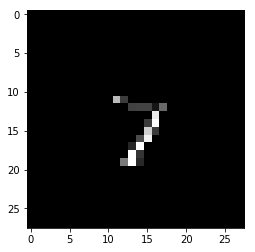

In [7]:
scale = 0.45 # Specifies the scaling factor of images.

# Define the train and test loader
# Here we are adding our CustomRotation function to the transformations
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       CustomScaling(scale),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       CustomScaling(scale),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=False, **kwargs)


## try out stuff

# transforms.functional.affine(img=transforms.functional.to_pil_image(example_data[0]),
#                              angle=0, translate=(0,0),
#                              scale=0.4, shear=0)


examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print("Predicted Class: ", 
      np.argmax(model.forward(example_data[0].unsqueeze_(0).cuda()).cpu().detach().numpy()))

plt.imshow(example_data[0].cuda().cpu().detach().numpy()[0], cmap='gray')
# transforms.functional.to_pil_image(example_data[0])

In [77]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable. 
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = model(data)
        # Calculate the loss The negative log likelihood loss. 
        # It is useful to train a classification problem with C classes.
        loss = F.nll_loss(output, target)
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        with torch.no_grad(): # volatile was removed and now 
            # has no effect. Use `with torch.no_grad():` instead.
            data= Variable(data)
        target = Variable(target)
        output = model(data)
        # sum up batch loss # size_average and reduce args will 
        # be deprecated, please use reduction='sum' instead.
        test_loss += F.nll_loss(output, target, reduction='sum').data 
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1] 
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Train the CNN model on normal MNIST images

We'll use stocastic gradient descend (SGD) as the optimizer and use momentum to lead the way. The hyperparameters are passed using `args` dictionary and the required key.

In [78]:
# optimizer = optim.SGD(model.parameters(), 
#                       lr=args['lr'], momentum=args['momentum'])
optimizer = optim.Adam(model.parameters(), lr=args['lr'])

# Training loop. 
# Change `args['log_interval']` if you want to change logging behavior.
# We test the network in each epoch.
# Setting the bool `args['train_now']` to not run training all the time.
# We'll save the weights and use the saved weights instead of 
# training the network everytime we load the jupyter notebook.


args['train_now'] = False
args['epochs'] = 30

if args['train_now']:
    for epoch in range(1, args['epochs'] + 1):
        train(epoch)
        test()
    torch.save(model.state_dict(), 'models/lenet5_normal_mnist.pytrh')
else:
    if args['cuda']:
        device = torch.device("cuda")
        model.load_state_dict(torch.load('models/lenet5_normal_mnist.pytrh'))
        model.to(device)
    else:
        model.load_state_dict(torch.load('models/lenet5_normal_mnist.pytrh'))
    model.eval()

## Kernel weight visualizations

Inorder to understand how the network learns, it is not only important to log the training and testing accuracies but also to visualize what the network learns. As we get over the deep learning hype, we should invest time in learning the intricate features which makes these networks what they are. As a first step, we shall write a custom visualization function to plot the kernels and activations of the CNN - whatever the size. This is a key piece of code that will drive us forward and unfortunately isn't available in Pytorch or internet :) So custom indeed.

In [79]:
def custom_boxplot(kernels, path=None, cols=None, size=None, verbose=False):
    """Statistical analysis using BoxPlot for weight and activation matrices
    learned during the optimization process. Works for any size of kernels.
    
    Arguments
    =========
    kernels: Weight or activation matrix. Must be a high dimensional
    Numpy array. Tensors will not work.
    path: Path to save the visualizations.
    cols: Number of columns (doesn't work completely yet.)
    size: Tuple input for size. For example: size=(5,5)
    verbose: Print information about the input.
    Example
    =======
    kernels = model.conv1.weight.cpu().detach().clone()
    kernels = kernels - kernels.min()
    kernels = kernels / kernels.max()
    custom_boxplot(kernels, 'results/conv1_weights_boxplot.png', 5, size=(25,5))
    """
    def set_size(w,h, ax=None):
        """ w, h: width, height in inches """
        if not ax: ax=plt.gca()
        l = ax.figure.subplotpars.left
        r = ax.figure.subplotpars.right
        t = ax.figure.subplotpars.top
        b = ax.figure.subplotpars.bottom
        figw = float(w)/(r-l)
        figh = float(h)/(t-b)
        ax.figure.set_size_inches(figw, figh)

    kernelshape = kernels.shape
    if verbose:
        print("Shape of input kernel: ", kernelshape)
        
    if cols==None:
        cols = 6
        rows = np.int(np.ceil(kernelshape[0]/cols))

    pos = range(1, kernelshape[0]+1)
    k=0
    fig = plt.figure(1)
    fig.tight_layout()
    
    for i in range(kernelshape[0]):
        ax = fig.add_subplot(rows,cols,pos[k])
        w_vol = np.reshape(kernels[k].cpu().detach().clone().numpy(), (kernelshape[1], kernelshape[2]*kernelshape[3]))
        w_vol_df = pd.DataFrame(w_vol.T)
        if verbose:
            msd = zip(w_vol_df.mean(), w_vol_df.std())
            for i, values in enumerate(msd):
                print("For kernel Volume %d" %i)
                print("Mean+-SD: %0.2f+-%0.2f" %values)
                print('----------------------')
        w_vol_df.boxplot(ax=ax)
        title_boxplot = 'Kernel ' + str(i)
        plt.title( title_boxplot )
        k+=1
        if k==kernelshape:
            break
    if size:
        size_h,size_w = size
        set_size(size_h,size_w,ax)
    if path:
        plt.savefig(path, dpi=100)
    plt.show()

In [80]:
def custom_viz(kernels, path=None, cols=None, size=None, verbose=False, axis=False, cmap='gray'):
    """Visualize weight and activation matrices learned 
    during the optimization process. Works for any size of kernels.
    
    Arguments
    =========
    kernels: Weight or activation matrix. Must be a high dimensional
    Numpy array. Tensors will not work.
    path: Path to save the visualizations.
    cols: Number of columns (doesn't work completely yet.)
    size: Tuple input for size. For example: size=(5,5)
    verbose: Print information about the input.
    axis: Plot axis for images.
    cmap: Color map for output images.
    Example
    =======
    kernels = model.conv1.weight.cpu().detach().clone()
    kernels = kernels - kernels.min()
    kernels = kernels / kernels.max()
    custom_viz(kernels, 'results/conv1_weights.png', 5)
    """
    def set_size(w,h, ax=None):
        """ w, h: width, height in inches """
        if not ax: ax=plt.gca()
        l = ax.figure.subplotpars.left
        r = ax.figure.subplotpars.right
        t = ax.figure.subplotpars.top
        b = ax.figure.subplotpars.bottom
        figw = float(w)/(r-l)
        figh = float(h)/(t-b)
        ax.figure.set_size_inches(figw, figh)
    
    N = kernels.shape[0]
    C = kernels.shape[1]
    total_cols = N*C
    pos = range(1,total_cols + 1)
    
    if verbose:
        print("Shape of input: ", kernels.shape)
        
    if cols==None:
        req_cols = C
        num_rows = N
    elif cols:
        req_cols = cols
        # Account for more rows while diving total cols
        # with requested number of cols in the figure
        # Hence, using np.ceil to get the largest int
        # from the quotient of division.
        num_rows = int(np.ceil(total_cols/req_cols))
    elif C>1:
        # Check for 1D arrays and such. Mostly not needed.
        req_cols = C

    fig = plt.figure(1)
    fig.tight_layout()
    k=0
    for i in range(kernels.shape[0]):
        for j in range(kernels.shape[1]):
            img = kernels[i][j]
            ax = fig.add_subplot(num_rows,req_cols,pos[k])
            if cmap:
                ax.imshow(img, cmap=cmap)
            else:
                ax.imshow(img)
            if axis:
                plt.axis('on')
            elif axis==False:
                plt.axis('off')
            k = k+1
    if size:
        size_h,size_w = size
        set_size(size_h,size_w,ax)
    if path:
        plt.savefig(path, dpi=100)
    plt.show()

In [111]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

print("Predicted Class: ", 
      np.argmax(model.forward(example_data[0].unsqueeze_(0).cuda()).cpu().detach().numpy()))

Predicted Class:  7


In [123]:
class SuperLeNet5(nn.Module):          
     
    def __init__(self):     
        super(SuperLeNet5, self).__init__()
        # Convolution (In LeNet-5, 32x32 images are given 
        # as input. Hence padding of 2 is done below)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, 
                                     kernel_size=9, stride=1, padding=2)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, 
                                     kernel_size=7, stride=1, padding=2)
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, 
                               kernel_size=5, stride=1, padding=2)
        # conv for 2nd branch
        self.b2conv1 = nn.Conv2d(in_channels=1, out_channels=6, 
                                     kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(5*5*120, 120)
        # convert matrix with 16*5*5 (= 400) features to a matrix of 120 features (columns)
        self.fc2 = nn.Linear(120, 84)       
        # convert matrix with 120 features to a matrix of 84 features (columns)
        self.fc3 = nn.Linear(84, 10)        
        # convert matrix with 84 features to a matrix of 10 features (columns)

            
    def forward(self, x):
        # convolve, then perform ReLU non-linearity
        x = F.relu(self.conv1(x))  
        # max-pooling with 2x2 grid 
        x = self.max_pool_1(x) 
        # Conv2 + ReLU
        x = F.relu(self.conv2(x))
        # max-pooling with 2x2 grid
        x = self.max_pool_2(x)
        # Conv3 + ReLU
        x = F.relu(self.conv3(x))
        x = x.view(-1, 5*5*120)
        # FC-1, then perform ReLU non-linearity
        x = F.relu(self.fc1(x))
        # FC-2, then perform ReLU non-linearity
        x = F.relu(self.fc2(x))
        # FC-3
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)

In [124]:
model_super = SuperLeNet5()
if args['cuda']:
    model_super.cuda()

summary(model_super, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             492
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3           [-1, 16, 10, 10]           4,720
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Conv2d-5            [-1, 120, 5, 5]          48,120
            Linear-6                  [-1, 120]         360,120
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 424,466
Trainable params: 424,466
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 1.62
Estimated Total Size (MB): 1.69
----------------------------------------------------------------


In [127]:
scale = 1 # Specifies the scaling factor of images.

# Define the train and test loader
# Here we are adding our CustomRotation function to the transformations
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       CustomScaling(scale),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       CustomScaling(scale),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=False, **kwargs)

def train(epoch):
    model_super.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable. 
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = model_super(data)
        # Calculate the loss The negative log likelihood loss. 
        # It is useful to train a classification problem with C classes.
        loss = F.nll_loss(output, target)
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))

def test():
    model_super.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        with torch.no_grad(): # volatile was removed and now 
            # has no effect. Use `with torch.no_grad():` instead.
            data= Variable(data)
        target = Variable(target)
        output = model_super(data)
        # sum up batch loss # size_average and reduce args will 
        # be deprecated, please use reduction='sum' instead.
        test_loss += F.nll_loss(output, target, reduction='sum').data 
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1] 
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [128]:
# optimizer = optim.SGD(model.parameters(), 
#                       lr=args['lr'], momentum=args['momentum'])
optimizer = optim.Adam(model_super.parameters(), lr=args['lr'])

# Training loop. 
# Change `args['log_interval']` if you want to change logging behavior.
# We test the network in each epoch.
# Setting the bool `args['train_now']` to not run training all the time.
# We'll save the weights and use the saved weights instead of 
# training the network everytime we load the jupyter notebook.


args['train_now'] = True

if args['train_now']:
    for epoch in range(1, args['epochs'] + 1):
        train(epoch)
        test()
    torch.save(model_super.state_dict(), 'models/superlenet5_normal_mnist.pytrh')
else:
    if args['cuda']:
        device = torch.device("cuda")
        model_super.load_state_dict(torch.load('models/superlenet5_normal_mnist.pytrh'))
        model_super.to(device)
    else:
        model_super.load_state_dict(torch.load('models/superlenet5_normal_mnist.pytrh'))
    model_super.eval()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304572
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.313608

Test set: Average loss: 0.1684, Accuracy: 9461/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.171967
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.156084

Test set: Average loss: 0.1269, Accuracy: 9606/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.098832
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.089912

Test set: Average loss: 0.0934, Accuracy: 9720/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.070504
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.067379

Test set: Average loss: 0.0802, Accuracy: 9750/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.068391
Train Epoch: 5 [40000/60000 (67%)]	Loss: 0.082421

Test set: Average loss: 0.1051, Accuracy: 9698/10000 (96%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.047800
Train Epoch: 6 [40000/60000 (67%)]	Loss: 0.051924

Test set: Average loss: 0.0844, Accuracy: 9753/10000 (97%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.061874
Train Epoch: 7 [400

## Scale the image to 29%

Predicted Class:  7


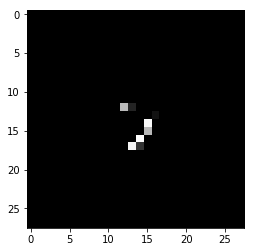

In [135]:
scale = 0.29 # Specifies the scaling factor of images.

# Define the train and test loader
# Here we are adding our CustomRotation function to the transformations
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       CustomScaling(scale),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       CustomScaling(scale),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=False, **kwargs)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print("Predicted Class: ", 
      np.argmax(model_super.forward(example_data[0].unsqueeze_(0).cuda()).cpu().detach().numpy()))

plt.imshow(example_data[0].cuda().cpu().detach().numpy()[0], cmap='gray')
# transforms.functional.to_pil_image(example_data[0])

## Duper Model

In [144]:
class DuperLeNet5(nn.Module):          
     
    def __init__(self):     
        super(DuperLeNet5, self).__init__()
        # Convolution (In LeNet-5, 32x32 images are given 
        # as input. Hence padding of 2 is done below)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, 
                                     kernel_size=3, stride=1, padding=2)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, 
                                     kernel_size=4, stride=1, padding=2)
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, 
                                     kernel_size=3, stride=1, padding=2)
        self.fc1 = nn.Linear(10*10*120, 120)
        # convert matrix with 16*5*5 (= 400) features to a matrix of 120 features (columns)
        self.fc2 = nn.Linear(120, 84)       
        # convert matrix with 120 features to a matrix of 84 features (columns)
        self.fc3 = nn.Linear(84, 10)        
        # convert matrix with 84 features to a matrix of 10 features (columns)

            
    def forward(self, x):
        # convolve, then perform ReLU non-linearity
        x = F.relu(self.conv1(x))  
        # max-pooling with 2x2 grid 
        x = self.max_pool_1(x) 
        # Conv2 + ReLU
        x = F.relu(self.conv2(x))
        # max-pooling with 2x2 grid
        x = self.max_pool_2(x)
        # Conv3 + ReLU
        x = F.relu(self.conv3(x))
        x = x.view(-1, 10*10*120)
        # FC-1, then perform ReLU non-linearity
        x = F.relu(self.fc1(x))
        # FC-2, then perform ReLU non-linearity
        x = F.relu(self.fc2(x))
        # FC-3
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)

In [145]:
model_duper = DuperLeNet5()
if args['cuda']:
    model_duper.cuda()

summary(model_duper, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 30, 30]              60
         MaxPool2d-2            [-1, 6, 15, 15]               0
            Conv2d-3           [-1, 16, 16, 16]           1,552
         MaxPool2d-4             [-1, 16, 8, 8]               0
            Conv2d-5          [-1, 120, 10, 10]          17,400
            Linear-6                  [-1, 120]       1,440,120
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 1,470,146
Trainable params: 1,470,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 5.61
Estimated Total Size (MB): 5.79
----------------------------------------------------------------


In [147]:
scale = 1 # Specifies the scaling factor of images.

# Define the train and test loader
# Here we are adding our CustomRotation function to the transformations
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       CustomScaling(scale),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       CustomScaling(scale),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=False, **kwargs)

args['epochs']=10

def train(epoch):
    model_duper.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable. 
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = model_duper(data)
        # Calculate the loss The negative log likelihood loss. 
        # It is useful to train a classification problem with C classes.
        loss = F.nll_loss(output, target)
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))

def test():
    model_duper.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        with torch.no_grad(): # volatile was removed and now 
            # has no effect. Use `with torch.no_grad():` instead.
            data= Variable(data)
        target = Variable(target)
        output = model_duper(data)
        # sum up batch loss # size_average and reduce args will 
        # be deprecated, please use reduction='sum' instead.
        test_loss += F.nll_loss(output, target, reduction='sum').data 
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1] 
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
# optimizer = optim.SGD(model.parameters(), 
#                       lr=args['lr'], momentum=args['momentum'])
optimizer = optim.Adam(model_duper.parameters(), lr=args['lr'])

# Training loop. 
# Change `args['log_interval']` if you want to change logging behavior.
# We test the network in each epoch.
# Setting the bool `args['train_now']` to not run training all the time.
# We'll save the weights and use the saved weights instead of 
# training the network everytime we load the jupyter notebook.


args['train_now'] = True

if args['train_now']:
    for epoch in range(1, args['epochs'] + 1):
        train(epoch)
        test()
    torch.save(model_duper.state_dict(), 'models/duperlenet5_normal_mnist.pytrh')
else:
    if args['cuda']:
        device = torch.device("cuda")
        model_duper.load_state_dict(torch.load('models/duperlenet5_normal_mnist.pytrh'))
        model_duper.to(device)
    else:
        model_duper.load_state_dict(torch.load('models/duperlenet5_normal_mnist.pytrh'))
    model_duper.eval()

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.024726
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.038723

Test set: Average loss: 0.0478, Accuracy: 9854/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.015334
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.024020

Test set: Average loss: 0.0389, Accuracy: 9888/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.015300
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.017980

Test set: Average loss: 0.0435, Accuracy: 9883/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.010114
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.009879

Test set: Average loss: 0.0419, Accuracy: 9900/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.011848
Train Epoch: 5 [40000/60000 (67%)]	Loss: 0.011133

Test set: Average loss: 0.0415, Accuracy: 9889/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.004958
Train Epoch: 6 [40000/60000 (67%)]	Loss: 0.014925

Test set: Average loss: 0.0500, Accuracy: 9887/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.008834
Train Epoch: 7 [400

Predicted Class:  5


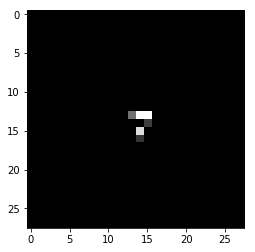

In [148]:
scale = 0.2 # Specifies the scaling factor of images.

# Define the train and test loader
# Here we are adding our CustomRotation function to the transformations
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       CustomScaling(scale),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data/', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       CustomScaling(scale),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=False, **kwargs)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print("Predicted Class: ", 
      np.argmax(model_duper.forward(example_data[0].unsqueeze_(0).cuda()).cpu().detach().numpy()))

plt.imshow(example_data[0].cuda().cpu().detach().numpy()[0], cmap='gray')
# transforms.functional.to_pil_image(example_data[0])